GameDefinition

In [23]:
from typing import TypedDict, List, Dict

class RoleDefinition(TypedDict):
    name: str
    description: str
    team: str

class GameDefinition(TypedDict):
    roles: Dict[str, RoleDefinition]
    role_distribution: List[str] 
    win_conditions: Dict[str, str]
    player_count: int
    phases: List[str]
    rules: List[str] 

game_def: GameDefinition = {
    "roles": {
        "villager": {
            "name": "villager",
            "description": "An ordinary villager with no special ability.",
            "team": "village"
        },
        "werewolf": {
            "name": "werewolf",
            "description": "A werewolf who tries to avoid being discovered.",
            "team": "werewolf"
        },
        "seer": {
            "name": "seer",
            "description": "Can inspect one player during the night to learn their role.",
            "team": "village"
        }
    },
    "role_distribution": [
        "villager",
        "villager",
        "werewolf",
        "seer",
        "werewolf"
    ],
    "win_conditions": {
        "village": "At least one werewolf is eliminated during the vote.",
        "werewolf": "No werewolf is eliminated during the vote."
    },
    "player_count": 5,
    "phases": ["night", "day", "vote"],
    "rules": [
        "The game consists of a single night, a single day discussion, and one vote.",
        "After the vote, the game ends immediately.",
        "There is no second night phase.",
        "Each role ability can be used at most once during the night.",
        "Only the voting result determines the winner."
    ]
}

① PlayerMemory（内部状態）を定義

これは GMが二度と直接触らないものです。

In [24]:
from typing import TypedDict, Dict, List, Optional

class PlayerMemory(TypedDict):
    self_name: str
    self_role: str
    beliefs: Dict[str, str]        # 他人の役職についての信念
    suspicion: Dict[str, float]    # 疑い度
    history: List[dict]            # 観測したイベント履歴

② PlayerInput（GM → PlayerGraph の入力）

In [25]:
class PlayerInput(TypedDict, total=False):
    event: dict            # 起きた出来事（speech / vote_result など）
    request: dict          # {"action": "speak"} / {"action": "vote"}

③ PlayerState（LangGraph用 State）

⚠️ 注意
ここでの state は 世界のstateではありません
「PlayerMemory + 今回入力」 です

In [26]:
class PlayerState(TypedDict):
    memory: PlayerMemory
    input: PlayerInput
    output: Optional[dict]   # {"message": "..."} / {"vote": "..."} / None

④ イベント処理ノード（listen）

In [27]:
def handle_event(state: PlayerState) -> PlayerState:
    event = state["input"].get("event")
    if not event:
        return state

    memory = state["memory"]
    memory["history"].append(event)

    if event["type"] == "speech":
        speaker = event["speaker"]
        content = event["content"]

        # 超シンプルな疑い更新ロジック
        if "suspicious" in content:
            memory["suspicion"][speaker] = memory["suspicion"].get(speaker, 0.0) + 0.2
        else:
            memory["suspicion"].setdefault(speaker, 0.1)

    return state

⑤ 行動決定ノード（speak / vote）

In [28]:
def decide_action(state: PlayerState) -> PlayerState:
    request = state["input"].get("request")
    if not request:
        return state

    memory = state["memory"]
    action = request.get("action")

    if action == "speak":
        if memory["suspicion"]:
            target = max(memory["suspicion"], key=memory["suspicion"].get)
            state["output"] = {
                "type": "speech",
                "speaker": memory["self_name"],
                "content": f"I think {target} is suspicious"
            }
        else:
            state["output"] = {
                "type": "speech",
                "speaker": memory["self_name"],
                "content": "I have no information"
            }

    elif action == "vote":
        target = max(memory["suspicion"], key=memory["suspicion"].get)
        state["output"] = {
            "type": "vote",
            "voter": memory["self_name"],
            "target": target
        }

    return state

⑥ PlayerGraph を組み立てる（LangGraph）

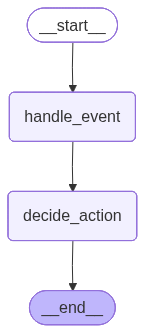

In [33]:
from langgraph.graph import StateGraph, END

player_graph = StateGraph(PlayerState)

player_graph.add_node("handle_event", handle_event)
player_graph.add_node("decide_action", decide_action)

player_graph.set_entry_point("handle_event")
player_graph.add_edge("handle_event", "decide_action")
player_graph.add_edge("decide_action", END)

compiled_player_graph = player_graph.compile()
compiled_player_graph 

⑦ 初期 PlayerMemory を作る（ゲーム開始時に1回だけ）

In [30]:
def init_player_memory(name: str, role: str, others: List[str]) -> PlayerMemory:
    return {
        "self_name": name,
        "self_role": role,
        "beliefs": {p: "unknown" for p in others},
        "suspicion": {p: 0.0 for p in others},
        "history": [],
    }

⑧ 実行例①：他人の発言を「聞く」

In [31]:
memory = init_player_memory("B", "villager", ["A", "C"])

state: PlayerState = {
    "memory": memory,
    "input": {
        "event": {
            "type": "speech",
            "speaker": "A",
            "content": "I think C is suspicious"
        }
    },
    "output": None
}

compiled_player_graph.invoke(state)

memory["suspicion"]

{'A': 0.2, 'C': 0.0}

⑨ 実行例②：発言を要求される

In [32]:
state = {
    "memory": memory,
    "input": {
        "request": {
            "action": "speak"
        }
    },
    "output": None
}

result = compiled_player_graph.invoke(state)
result["output"]

{'type': 'speech', 'speaker': 'B', 'content': 'I think A is suspicious'}